In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model35/keras/model35/1/model3 (3).keras
/kaggle/input/motion-prediction/keras/motion250/1/motion250.keras
/kaggle/input/motion-prediction/keras/motion2/1/motion2.keras
/kaggle/input/motion-prediction/keras/motion/1/motion.keras


In [2]:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2024.6.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    filelock-3.15.1            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       h4ab18f5_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.15.1-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdow

In [3]:
!gdown --id 1-1B1AB4em_cUr5LYvhL15gvNlLndOTDX

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-1B1AB4em_cUr5LYvhL15gvNlLndOTDX
From (redirected): https://drive.google.com/uc?id=1-1B1AB4em_cUr5LYvhL15gvNlLndOTDX&confirm=t&uuid=9a80c5aa-f804-4474-9fce-3d7bd1f8ea86
To: /kaggle/working/final.npz
100%|███████████████████████████████████████| 3.94G/3.94G [00:20<00:00, 189MB/s]


In [4]:
!gdown --id 1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj
From (redirected): https://drive.google.com/uc?id=1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj&confirm=t&uuid=680082e5-99c4-4c39-80c4-43980b8b3e44
To: /kaggle/working/test.npz
100%|███████████████████████████████████████| 1.37G/1.37G [00:11<00:00, 116MB/s]


In [8]:
%cp /kaggle/working/final.npz /kaggle/input/

cp: cannot create regular file '/kaggle/input/final.npz': Read-only file system


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, UpSampling2D, Conv2D, TimeDistributed, Lambda, Dense, Reshape, Flatten ,GRU,LSTM,MaxPooling2D,Conv2DTranspose
# from tensorflow.keras.applications import ResNet50,MobileNetV2,EfficientNetB0
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam ,RMSprop ,Adagrad


2024-06-15 03:10:50.223626: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 03:10:50.223728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 03:10:50.489453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
data = np.load('/kaggle/working/final.npz')

# Accéder aux tableaux individuels
input_sequences = data['input']
target_sequences = data['target']


In [7]:
del data

In [8]:
testdata = np.load('/kaggle/working/test.npz')

# Accéder aux tableaux individuels
test_input_sequences = testdata['input']
test_target_sequences = testdata['target']

validation_input_sequences = test_input_sequences[0:30]
validation_target_sequences = test_target_sequences[0:30]

In [9]:
del testdata

In [10]:
import tensorflow as tf
if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

    with strategy.scope():
        
        def modèle_prédiction_mouvement(images):
            # Vérifier que les images sont au bon format
            assert len(images.shape) == 5, "Les images doivent être sous la forme [batch_size, sequence_length, height, width, channels]"

            batch_size, sequence_length, height, width, channels = images.shape

            # Extraire les caractéristiques
            modèle_extraction = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(height, width, channels)),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Conv2D(64, 3, activation='relu'),
                tf.keras.layers.MaxPooling2D(),
                tf.keras.layers.Flatten(),
            ])

            # Reconstruire la séquence
            modèle_reconstruction = tf.keras.Sequential([
                tf.keras.layers.LSTM(128, return_sequences=True),
                tf.keras.layers.LSTM(64),
                tf.keras.layers.Dense(sequence_length * height * width * channels, activation='sigmoid'),
                tf.keras.layers.Reshape((sequence_length, height, width, channels))
            ])

            # Modèle complet
            entrées = tf.keras.Input(shape=(sequence_length, height, width, channels))
            caractéristiques = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, 3, activation='relu'))(entrées)
            caractéristiques = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(caractéristiques)
            caractéristiques = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(64, 3, activation='relu'))(caractéristiques)
            caractéristiques = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D())(caractéristiques)
            caractéristiques = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(caractéristiques)

            sorties = modèle_reconstruction(caractéristiques)
            

            modèle = tf.keras.Model(inputs=entrées, outputs=sorties)

            # Compilation du modèle (vous pouvez ajuster la fonction de perte et l'optimiseur)
            modèle.compile(loss='mse', optimizer='adam')
            return modèle
        def sequence_generator(input_sequences, target_sequences, batch_size):
            while True:
                indices = np.random.permutation(len(input_sequences))
                for i in range(0, len(input_sequences), batch_size):
                    batch_indices = indices[i:i + batch_size]
                    input_seq = np.array([input_sequences[j] for j in batch_indices])
                    target_seq = np.array([target_sequences[j] for j in batch_indices])
                    yield input_seq, target_seq
        
        
        models= modèle_prédiction_mouvement(input_sequences)
        batch_size = 6
        epochs = 100
        validation_steps = len(validation_input_sequences) // batch_size
        steps_per_epoch = len(input_sequences) // batch_size
        train_gen = sequence_generator(input_sequences, target_sequences, batch_size)
        validation_gen = sequence_generator(validation_input_sequences, validation_target_sequences, batch_size)
        
        checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

        
        history = models.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,validation_data=validation_gen,validation_steps=validation_steps,callbacks=[checkpoint, early_stopping])


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/replica_1/functional_7_1/time_distributed_8_1/strided_slice_33/StridedSliceGrad defined at (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 66, in train_step

Detected at node gradient_tape/functional_7_1/time_distributed_8_1/strided_slice_51/StridedSliceGrad defined at (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 66, in train_step

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[59,3,61,61,64] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node gradient_tape/replica_1/functional_7_1/time_distributed_8_1/strided_slice_33/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[59,3,61,61,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/functional_7_1/time_distributed_8_1/strided_slice_51/StridedSliceGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_55934]

In [10]:
md = modèle_prédiction_mouvement(input_sequences)

In [18]:
  modèle_extraction = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
  ])

In [22]:
modèle_extraction(input_sequences[0])

<tf.Tensor: shape=(59, 57600), dtype=float32, numpy=
array([[0.27201158, 0.01886193, 0.        , ..., 0.        , 0.14426687,
        0.        ],
       [0.24044703, 0.03972537, 0.        , ..., 0.        , 0.14176767,
        0.        ],
       [0.24020477, 0.04980506, 0.        , ..., 0.        , 0.14236605,
        0.        ],
       ...,
       [0.25970796, 0.03683881, 0.        , ..., 0.        , 0.1425926 ,
        0.        ],
       [0.26056525, 0.0384835 , 0.        , ..., 0.        , 0.14786248,
        0.        ],
       [0.2600209 , 0.03975646, 0.        , ..., 0.        , 0.14635184,
        0.        ]], dtype=float32)>

In [7]:
target_sequences[0].shape

(59, 128, 128, 3)

In [23]:
tf.config.run_functions_eagerly(True)

In [12]:
if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

    with strategy.scope():
        # Dimensions des images
        img_height, img_width, img_channels = 128, 128, 3
        seq_length = 59  # Longueur fixe de la séquence

        def create_model(input_shape):
            encoder_inputs = Input(shape=input_shape)
            encoded_seq = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'))(encoder_inputs)
            encoded_seq = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(encoded_seq)
            encoded_seq = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(encoded_seq)
            encoded_seq = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(encoded_seq)

            encoded_seq = ConvLSTM2D(32, (3, 3), activation='relu', padding='same', return_sequences=True)(encoded_seq)
            encoded_seq_reshaped = Reshape((seq_length, -1))(encoded_seq)

            decoded_seq = GRU(512, return_sequences=True)(encoded_seq_reshaped)
            decoded_seq = GRU(512, return_sequences=True)(decoded_seq)
            output_vector_seq = TimeDistributed(Dense(img_height * img_width * img_channels, activation='sigmoid'))(decoded_seq)
            output_image_seq = Reshape((seq_length, img_height, img_width, img_channels))(output_vector_seq)

            model = Model(encoder_inputs, output_image_seq)
            model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss='mse')
            return model

        input_shape = (seq_length, img_height, img_width, img_channels)  # Séquences de longueur fixe
        model = create_model(input_shape)

        # Fonction de générateur pour les séquences
        def sequence_generator(input_sequences, target_sequences, batch_size):
            while True:
                indices = np.random.permutation(len(input_sequences))
                for i in range(0, len(input_sequences), batch_size):
                    batch_indices = indices[i:i + batch_size]
                    input_seq = np.array([input_sequences[j] for j in batch_indices])
                    target_seq = np.array([target_sequences[j] for j in batch_indices])
                    yield input_seq, target_seq

        batch_size = 6
        epochs = 100

        validation_steps = len(validation_input_sequences) // batch_size
        steps_per_epoch = len(input_sequences) // batch_size
        train_gen = sequence_generator(input_sequences, target_sequences, batch_size)
        validation_gen = sequence_generator(validation_input_sequences, validation_target_sequences, batch_size)

        checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

        history = model.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                            validation_data=validation_gen, validation_steps=validation_steps,
                            callbacks=[checkpoint, early_stopping])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Epoch 1/100


2024-06-12 13:09:19.171131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/cond/else/_140/cond/StatefulPartitionedCall/functional_1_1/conv_lstm2d_1/while/body/_1508/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul' -> 'StatefulPartitionedCall/cond/else/_140/cond/StatefulPartitionedCall/functional_1_1/conv_lstm2d_1/while/body/_1508/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/cond/else/_140/cond/StatefulPartitionedCall/functional_1_1/conv_lstm2d_1/while/body/_1508/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/Sigmoid' -> 'StatefulPartitionedCall/cond/else/_140/cond/StatefulPartitionedCall/functional_1_1/conv_lstm2d_1/while/body/_1508/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_1', 'StatefulPartitionedCall/cond/else/_140/cond/StatefulPartitionedCall/functional_1_1/conv_lstm2d

28/28 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - loss: 0.0576 - val_loss: 0.0608
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 960ms/step - loss: 0.0536 - val_loss: 0.0603
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 938ms/step - loss: 0.0490 - val_loss: 0.0571
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 953ms/step - loss: 0.0477 - val_loss: 0.0560
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 952ms/step - loss: 0.0445 - val_loss: 0.0545
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 946ms/step - loss: 0.0437 - val_loss: 0.0535
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 942ms/step - loss: 0.0415 - val_loss: 0.0524
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 795ms/step - loss: 0.0433 - val_loss: 0.0527
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 949ms/step - loss: 0.0405 - val_loss: 0.0487
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 798ms/step - loss: 0.0401 - val_loss: 0.0494
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 795ms/step - loss: 0.0421 - val_loss: 0.0549
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 7

In [13]:
model.save('motionV.keras')

### input_sequences[0].shape

## Test the Model

In [11]:
!gdown --id 1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj
From (redirected): https://drive.google.com/uc?id=1MISRjmQMh3vaKqY5dsFI87htxb9xvdyj&confirm=t&uuid=160a267d-a9bc-4aba-ba7c-c8d839b736c0
To: /kaggle/working/test.npz
100%|███████████████████████████████████████| 1.37G/1.37G [00:08<00:00, 168MB/s]


In [29]:
testdata = np.load('/kaggle/working/test.npz')

# Accéder aux tableaux individuels
test_input_sequences = testdata['input']
test_target_sequences = testdata['target']

In [14]:
model.evaluate(test_input_sequences,test_target_sequences,verbose=1)


2024-06-12 13:26:52.438912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/replica_1/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/Relu_1' -> 'replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/replica_1/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul_2', 'Func/replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/input/_174' -> 'replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/replica_1/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/mul', 'replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/replica_1/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/convolution_7' -> 'replica_1/functional_1_1/conv_lstm2d_1/while/body/_58/replica_1/functional_1_1/conv_lstm2d_1/while/conv_lstm_cell_1/add_8', 'functional_1_1/conv_lstm2d_1/while/body/_15/functional_1_1/conv_lstm2d_1/while/conv_lst

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - loss: 0.0485


0.04545437544584274

In [15]:
predictions = model.predict(test_input_sequences)

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step


In [15]:
predictions.shape

(59, 59, 128, 128, 3)

In [25]:
pred = model.predict(np.reshape(input_sequences[0], (1, 59, 128, 128, 3) ))           

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


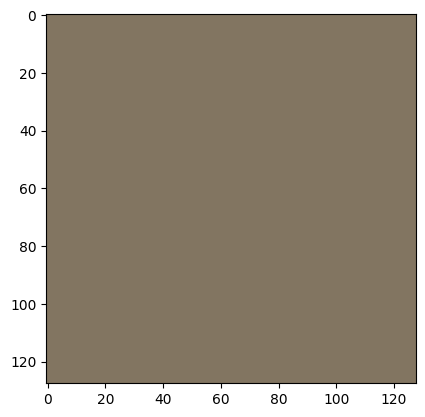

In [26]:
plt.imshow(pred[0][58])

In [11]:
import matplotlib.pyplot as plt

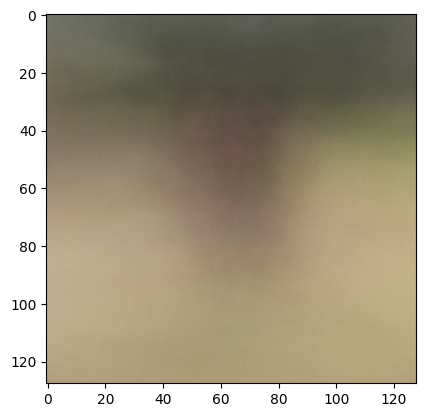

In [17]:
plt.imshow(predictions[8][1])

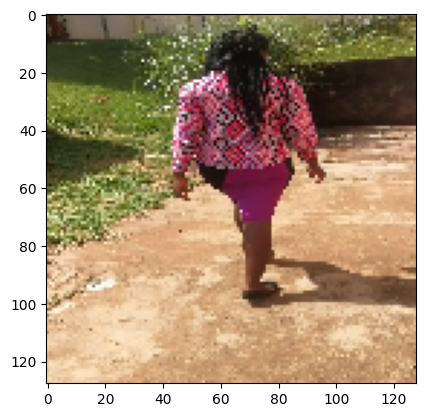

In [37]:
plt.imshow(test_input_sequences[8][1])

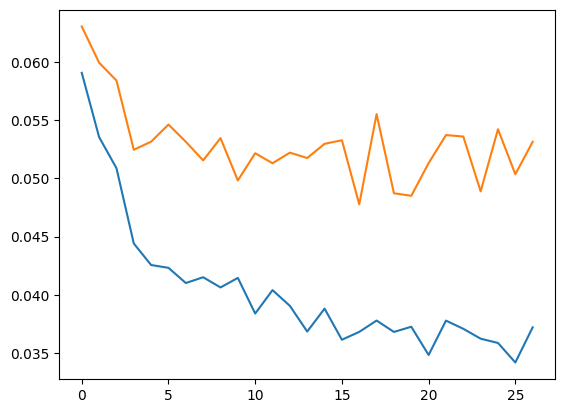

In [32]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## **Another Expriment Tracking**

In [27]:
from tensorflow.keras.models import Sequential


if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

    with strategy.scope():
        height, width, channels = 128, 128, 3
        seq_length = 59
# Define the model
        model4 = Sequential()

        # Encoder
        model4.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), input_shape=(None, height, width, channels), padding='same', return_sequences=False))
        # Decoder
        model4.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True))
        model4.add(ConvLSTM2D(filters=1, kernel_size=(3, 3), padding='same', return_sequences=True))

        # Compile the model
        model4.compile(optimizer='adam', loss='mse')
        
        batch_size = 6
        # Train the model
        model4.fit(train_gen,batch_size=batch_size , epochs=15, validation_data=validation_gen)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


ValueError: Input 0 of layer "conv_lstm2d_14" is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, 128, 128, 64)

In [29]:
model4(np.reshape(input_sequences[0], (1, 59, 128, 128, 3)))

ValueError: Sequential model 'sequential_7' has already been configured to use input shape (None, None, 128, 128, 3). You cannot build it with input_shape (1, 59, 128, 128, 3)

In [11]:
from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import BatchNormalization

In [10]:
if tf.test.is_gpu_available():
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

    with strategy.scope():
        

#         seq = Sequential()

#         seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
#                            input_shape=(None, 128, 128, 3),
#                            padding='same', return_sequences=True))
#         seq.add(BatchNormalization())

#         seq.add(ConvLSTM2D(filters=20, kernel_size=(3, 3),
#                            padding='same', return_sequences=True))
#         seq.add(BatchNormalization())

#         seq.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
#                            padding='same', return_sequences=True))
#         seq.add(BatchNormalization())

#         seq.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
#                            padding='same', return_sequences=True))
#         seq.add(BatchNormalization())

#         seq.add(Conv3D(filters=3, kernel_size=(3, 3, 3),
#                        activation='sigmoid',
#                        padding='same', data_format='channels_last'))
#         seq.compile(loss='mae', optimizer='rmsprop')
        seq = tf.keras.models.load_model('/kaggle/input/model35/keras/model35/1/model3 (3).keras')
        checkpoint = ModelCheckpoint('model3.keras', monitor='val_loss', save_best_only=True, mode='min')
        history = seq.fit(input_sequences,target_sequences, batch_size=6,
        epochs=100, validation_data=(validation_input_sequences,validation_target_sequences),callbacks=[checkpoint])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Epoch 1/100


2024-06-15 03:14:02.828584: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/Sigmoid_2' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul_2', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/add_7', 'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/Sigmoid_1' -> 'StatefulPartitionedCall/sequential_1/conv_lstm2d_3_1/while/body/_723/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul', 'Statef

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1474

2024-06-15 03:15:20.235214: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/convolution_7' -> 'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/ArithmeticOptimizer/AddOpsRewrite_Leaf_1_add_8', 'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul' -> 'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/add_7', 'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/Tanh_1' -> 'sequential_1/conv_lstm2d_3_1/while/body/_130/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul_2', 'sequential_1/conv_lstm2d_2_1/while/body/_87/sequential_1/conv_lstm2d_2_1/while/conv_lstm_cell_1/convolution_

29/29 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 0.1474 - val_loss: 0.1844
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1434 - val_loss: 0.1914
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1445 - val_loss: 0.1838
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1451 - val_loss: 0.1800
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1470 - val_loss: 0.1799
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1443 - val_loss: 0.1820
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1423 - val_loss: 0.1799
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1411 - val_loss: 0.1812
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1445 - val_loss: 0.1812
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1476 - val_loss: 0.1807
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1458 - val_loss: 0.1795
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.1473 - val_lo

In [14]:
seq.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, None, 128, 128, │        62,080 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, None, 128, 128, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, None, 128, 128, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, None, 128, 128, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, None, 128, 128, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, None, 128, 128, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, None, 128, 128, │       115,360 │
│                                 │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, None, 128, 128, │           160 │
│ (BatchNormalization)            │ 40)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, None, 128, 128, │         3,243 │
│                                 │ 3)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,043 (1.57 MB)

 Trainable params: 411,723 (1.57 MB)

 Non-trainable params: 320 (1.25 KB)

In [14]:
model1 = tf.keras.models.load_model('/kaggle/input/model35/keras/model35/1/model3 (3).keras')

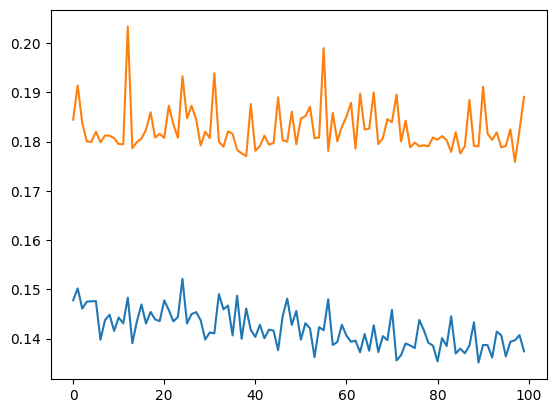

In [12]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [14]:
seq.evaluate(test_input_sequences,test_target_sequences,verbose=1)


2024-06-15 05:10:46.875360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'sequential_1/conv_lstm2d_3_1/while/sequential_1/conv_lstm2d_3_1/zeros_switch/_167-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'sequential_1/conv_lstm2d_3_1/while/sequential_1/conv_lstm2d_3_1/zeros_switch/_167', 'sequential_1/conv_lstm2d_3_1/while/body/_144/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/mul' -> 'sequential_1/conv_lstm2d_3_1/while/body/_144/sequential_1/conv_lstm2d_3_1/while/conv_lstm_cell_1/add_7', 'sequential_1/conv_lstm2d_2_1/while/sequential_1/conv_lstm2d_2_1/zeros_switch/_124-0-TransposeNHWCToNCHW-LayoutOptimizer' -> 'sequential_1/conv_lstm2d_2_1/while/sequential_1/conv_lstm2d_2_1/zeros_switch/_124', 'Func/sequential_1/conv_lstm2d_2_1/while/body/_101/input/_467' -> 'sequential_1/conv_lstm2d_2_1/while/body/_101/sequential_1/conv_lstm2d_2_1/while/conv_lstm_cell_1/mul

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - loss: 0.1683


0.16644640266895294

In [16]:
predictions = seq.predict(test_input_sequences)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


In [17]:
pred = model1.predict(test_input_sequences)

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step


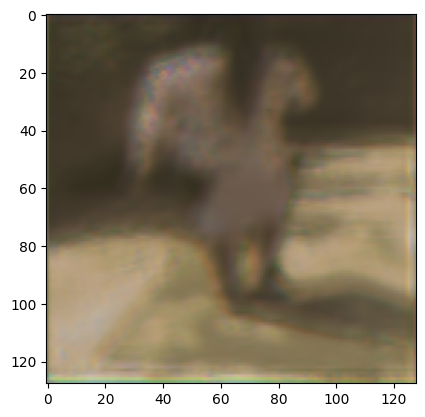

In [21]:
plt.imshow(predictions[9][0])

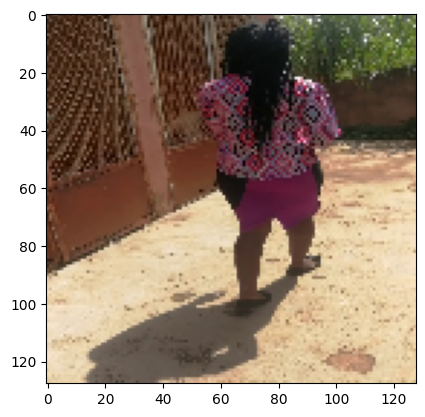

In [22]:
plt.imshow(test_input_sequences[1][0])

In [22]:
import cv2
import numpy as np
import tensorflow as tf

In [31]:
# Fonction pour normaliser les images entre 0 et 255
def denormalize(img):
    img = img - img.min()
    img = img / img.max()
    img = (img * 255).astype(np.uint8)
    return img

# Fonction pour écrire la vidéo
def write_video(predicted_sequences, output_file):
    # Dimensions des images
    seq_length, img_height, img_width, img_channels = predicted_sequences.shape

    # Définir le codec et créer l'objet VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_file, fourcc, 5.0, (img_width, img_height))

    for j in range(seq_length):
        frame = predicted_sequences[j]
        frame = denormalize(frame) # Dénormaliser l'image pour qu'elle soit entre 0 et 255
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    out.release()
    print(f"Vidéo enregistrée sous {output_file}")

In [32]:
write_video(predictions[0], 'output_video_0.avi')

Vidéo enregistrée sous output_video_0.avi


In [27]:
write_video(input_sequences[0], 'input_video.avi')

Vidéo enregistrée sous input_video.avi


In [28]:
predictions[1].shape

(59, 128, 128, 3)